
ANN MODEL PERFORMANCE
R2 Score: 0.8345
Mean Squared Error: 1868.36

Sample Predictions:
     Actual Hydro  Actual Digester  Pred Hydro  Pred Digester
58          400.0            400.0  407.051148     406.060157
33          350.0            350.0  344.679106     343.422190
82          400.0            400.0  400.509233     400.336270
140         400.0            400.0  395.813050     399.562857
2           100.0            150.0  179.449053     160.791491

Generating SHAP Explanations...
This may take a minute as KernelExplainer is computationally intensive...

>> Explaining 'Recommended Feed to Hydrolyser'...


  0%|          | 0/19 [00:00<?, ?it/s]

   Saved 'shap_summary_ann_hydro.png'

>> Explaining 'Recommonded Feed to Digester'...


  0%|          | 0/19 [00:00<?, ?it/s]

   Saved 'shap_summary_ann_digester.png'

SHAP analysis complete.


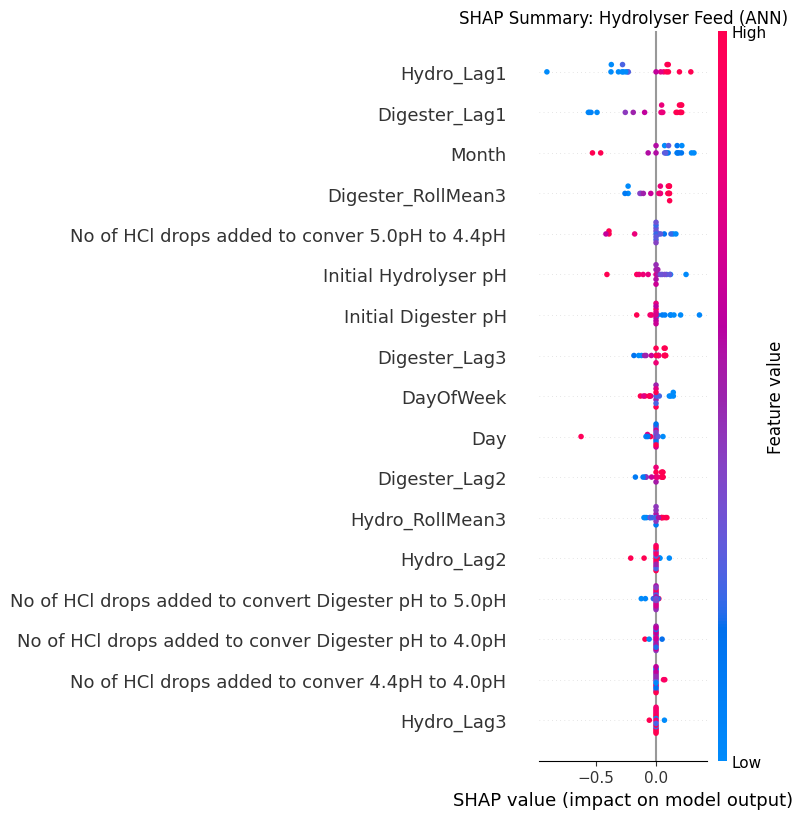

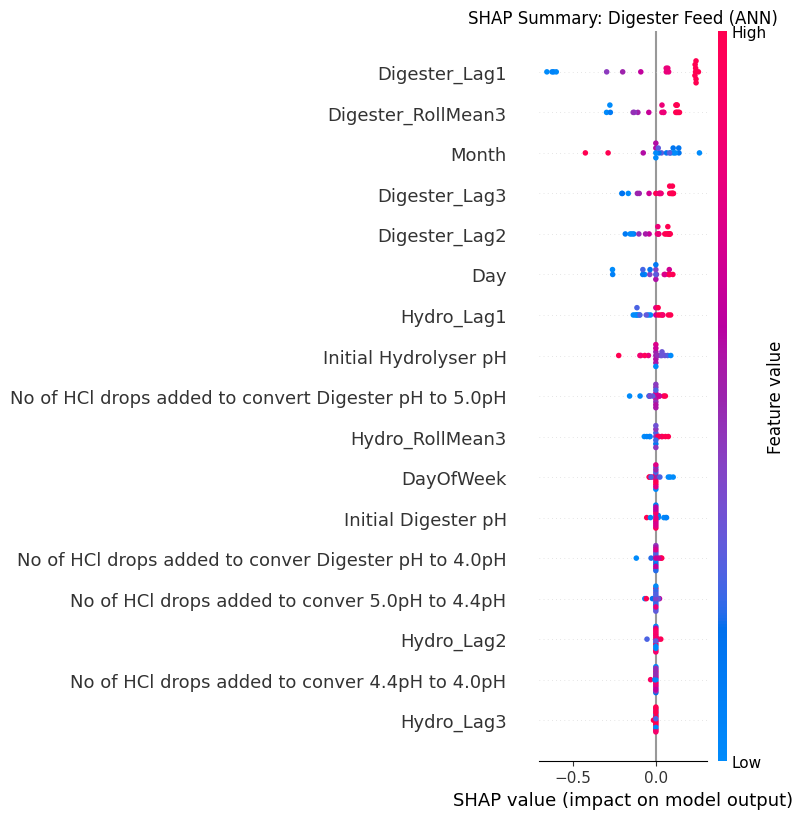

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Try to import SHAP
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("Warning: 'shap' library not found. Install it using 'pip install shap'.")

# ==========================================
# 1. Load and Preprocess Data
# ==========================================
file_path = 'combined_file.csv'
df = pd.read_csv(file_path)

# Robust Date Parsing
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.sort_values('Date')

# Feature Engineering: Time Series Lags
df_filled = df.copy()
df_filled['Recommended Feed to Hydrolyser'] = df_filled['Recommended Feed to Hydrolyser'].ffill()
df_filled['Recommonded Feed to Digester'] = df_filled['Recommonded Feed to Digester'].ffill()

for lag in [1, 2, 3]:
    df[f'Hydro_Lag{lag}'] = df_filled['Recommended Feed to Hydrolyser'].shift(lag)
    df[f'Digester_Lag{lag}'] = df_filled['Recommonded Feed to Digester'].shift(lag)

df['Hydro_RollMean3'] = df_filled['Recommended Feed to Hydrolyser'].shift(1).rolling(window=3).mean()
df['Digester_RollMean3'] = df_filled['Recommonded Feed to Digester'].shift(1).rolling(window=3).mean()

df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

X_cols = [
    'Initial Hydrolyser pH', 'Initial Digester pH',
    'No of HCl drops added to convert Digester pH to 5.0pH',
    'No of HCl drops added to conver 5.0pH to 4.4pH',
    'No of HCl drops added to conver 4.4pH to 4.0pH',
    'No of HCl drops added to conver Digester pH to 4.0pH',
    'Hydro_Lag1', 'Hydro_Lag2', 'Hydro_Lag3',
    'Digester_Lag1', 'Digester_Lag2', 'Digester_Lag3',
    'Hydro_RollMean3', 'Digester_RollMean3',
    'Month', 'Day', 'DayOfWeek'
]

y_cols = ['Recommended Feed to Hydrolyser', 'Recommonded Feed to Digester']

df_clean = df.dropna(subset=X_cols + y_cols).copy()
X = df_clean[X_cols]
y = df_clean[y_cols]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# ==========================================
# 2. Train ANN Model
# ==========================================
model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='lbfgs',
    max_iter=10000,
    alpha=0.005,
    random_state=42
)

model.fit(X_train_scaled, y_train_scaled)

# ==========================================
# 3. Evaluate and Show Results
# ==========================================
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("\n" + "="*40)
print(f"ANN MODEL PERFORMANCE")
print("="*40)
print(f"R2 Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.2f}")

results_df = pd.DataFrame(
    y_test.values,
    columns=['Actual Hydro', 'Actual Digester'],
    index=y_test.index
)
results_df['Pred Hydro'] = y_pred[:, 0]
results_df['Pred Digester'] = y_pred[:, 1]

print("\nSample Predictions:")
print(results_df.head())

# ==========================================
# 4. Explainable AI (SHAP) - FIXED
# ==========================================
if SHAP_AVAILABLE:
    print("\nGenerating SHAP Explanations...")
    print("This may take a minute as KernelExplainer is computationally intensive...")

    # 1. Create a Summary Background (Speeds up calculation)
    # We use k-means to reduce the training data to 10 representative points
    X_train_summary = shap.kmeans(X_train_scaled, 10)

    # --- EXPLAIN TARGET 1: HYDROLYSER FEED ---
    print("\n>> Explaining 'Recommended Feed to Hydrolyser'...")

    # WRAPPER FUNCTION: This creates a function that predicts ONLY the 1st target column
    # This prevents the shape mismatch error by ensuring SHAP sees a single output
    def predict_hydrolyser(x):
        return model.predict(x)[:, 0]

    # Initialize Explainer with the wrapper
    explainer_hydro = shap.KernelExplainer(predict_hydrolyser, X_train_summary)

    # Calculate SHAP values (result is a simple array now, not a list)
    shap_values_hydro = explainer_hydro.shap_values(X_test_scaled)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.title("SHAP Summary: Hydrolyser Feed (ANN)")
    shap.summary_plot(shap_values_hydro, X_test_scaled, feature_names=X_cols, show=False)
    plt.tight_layout()
    plt.savefig('shap_summary_ann_hydro.png')
    print("   Saved 'shap_summary_ann_hydro.png'")

    # --- EXPLAIN TARGET 2: DIGESTER FEED ---
    print("\n>> Explaining 'Recommonded Feed to Digester'...")

    # WRAPPER FUNCTION for the 2nd target
    def predict_digester(x):
        return model.predict(x)[:, 1]

    explainer_dig = shap.KernelExplainer(predict_digester, X_train_summary)
    shap_values_dig = explainer_dig.shap_values(X_test_scaled)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.title("SHAP Summary: Digester Feed (ANN)")
    shap.summary_plot(shap_values_dig, X_test_scaled, feature_names=X_cols, show=False)
    plt.tight_layout()
    plt.savefig('shap_summary_ann_digester.png')
    print("   Saved 'shap_summary_ann_digester.png'")

    print("\nSHAP analysis complete.")
else:
    print("\nSkipping SHAP analysis (library not installed).")